In [54]:
import sys
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
  
# append the path of the parent directory
sys.path.append("..")

Helper Functions

In [55]:
def load_metadata(root_path):
    """Load metadata from JSON files into a dict of dicts.

    Args:
        root_path (str): The root directory containing model subdirectories.

    Returns:
        dict: A dictionary with model IDs as keys and metadata dictionaries as values.
    """
    metadata_dict = {}
    for model_dir in os.listdir(root_path):
        model_path = os.path.join(root_path, model_dir)
        if os.path.isdir(model_path):
            metadata_file = os.path.join(model_path, f"{model_dir}_metadata.json")
            if os.path.isfile(metadata_file):
                with open(metadata_file, 'r') as file:
                    metadata_dict[model_dir] = json.load(file)
    return metadata_dict

Exploration / Visualisation Functions


In [78]:
def plot_resolution_histogram(metadata, resolution_axis):
    """Plot a histogram of the resolutions in the metadata for a specified axis.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
        resolution_axis (str): The axis to plot the resolution histogram for ('x' or 'y').
    """
    # Ensure that the resolution_axis is either 'x' or 'y'
    if resolution_axis not in ('x', 'y'):
        raise ValueError("resolution_axis must be 'x' or 'y'")

    # Extract the resolutions for the specified axis
    resolutions = [model_data[f'grid_resolution_{resolution_axis}'] for model_data in metadata.values()]

    # Plot histogram for the specified resolutions
    plt.figure(figsize=(7, 5))
    plt.hist(resolutions, bins=20, color='blue' if resolution_axis == 'x' else 'green', edgecolor='black')
    plt.title(f'Histogram of {resolution_axis.upper()} Resolutions')
    plt.xlabel('Resolution')
    plt.ylabel('Frequency')
    plt.show()

def find_different_resolutions(metadata):
    """Find models where X and Y resolutions are different along with their respective resolution values.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.

    Returns:
        dict: A dictionary with model IDs as keys and tuples of (x_resolution, y_resolution) as values
              for models where the X and Y resolutions are not the same.
    """
    different_resolutions = {}

    for model_id, model_data in metadata.items():
        # Access the resolutions directly as in the previous examples
        x_res = model_data.get('grid_resolution_x')
        y_res = model_data.get('grid_resolution_y')
        if x_res != y_res:
            different_resolutions[model_id] = (x_res, y_res)

    return different_resolutions

def models_with_low_resolution(metadata, resolution_threshold):
    """Find models with either x_resolution or y_resolution less than 1.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.

    Returns:
        list: A list of model IDs with either x_resolution or y_resolution less than 1.
    """
    low_resolution_models = []



    for model_id, model_data in metadata.items():
        x_res = model_data.get('grid_resolution_x', float('inf'))
        y_res = model_data.get('grid_resolution_y', float('inf'))
        if x_res < resolution_threshold or y_res < resolution_threshold:
            low_resolution_models.append(model_id)

    return low_resolution_models

def list_models_with_nonstandard_resolution(metadata, target_resolution=2.0):
    """List all models with a resolution that is not exactly the target resolution for either axis.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
        target_resolution (float, optional): The resolution to compare against. Default is 2.0 meters.

    Returns:
        list: A list of model identifiers that have a resolution other than the specified target resolution for either axis.
    """
    # List to hold the model IDs with resolutions not equal to the target
    models_with_nonstandard_resolution = []

    # Iterate through the models in the metadata
    for model_id, model_data in metadata.items():
        # Check if either x or y resolutions are not equal to the target resolution
        if (model_data['grid_resolution_x'] != target_resolution or
                model_data['grid_resolution_y'] != target_resolution):
            models_with_nonstandard_resolution.append(model_id)

    return models_with_nonstandard_resolution






def plot_average_timestep_histogram(metadata):
    """Plot a histogram of the average timestep in the metadata.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
    """
    # Extract the average timesteps
    average_timesteps = [model_data['average_timestep'] for model_data in metadata.values()]

    # Plot histogram for average timesteps
    plt.figure(figsize=(7, 5))
    plt.hist(average_timesteps, bins=20, color='purple', edgecolor='black')
    plt.title('Histogram of Average Timestep')
    plt.xlabel('Average Timestep')
    plt.ylabel('Frequency')
    plt.show()

def plot_dimensions_scatter(metadata):
    """Plot a scatter plot of the x_dimension and y_dimension and label the largest model.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
    """
    # Extract x_dimension and y_dimension
    x_dimensions = [model_data['x_dimension'] for model_data in metadata.values()]
    y_dimensions = [model_data['y_dimension'] for model_data in metadata.values()]
    model_ids = list(metadata.keys())

    # Calculate the area (product of dimensions) to find the largest model
    areas = np.array(x_dimensions) * np.array(y_dimensions)
    largest_model_index = np.argmax(areas)
    largest_model_id = model_ids[largest_model_index]

    # Plot scatter plot
    plt.figure(figsize=(10, 7))
    plt.scatter(x_dimensions, y_dimensions, color='orange', edgecolor='black')
    
    # Highlight and label the largest model
    plt.scatter(x_dimensions[largest_model_index], y_dimensions[largest_model_index], color='red')
    plt.text(x_dimensions[largest_model_index], y_dimensions[largest_model_index], f'Model {largest_model_id}',
             fontsize=12, ha='right')

    plt.title('Scatter Plot of x_dimension vs y_dimension')
    plt.xlabel('x_dimension')
    plt.ylabel('y_dimension')
    plt.grid(True)
    plt.show()

def plot_debris_bounding_boxes(metadata):
    """Plot a scatter plot of the width and height of bounding boxes for debris across all states in each model.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
                         Each metadata contains a 'bounding_boxes' dictionary with state IDs as keys.
    """
    widths = []
    heights = []

    # Iterate over each model and its states to extract the bounding box dimensions
    for model_data in metadata.values():
        bounding_boxes = model_data.get('bounding_boxes', {})
        for state_id, bbox in bounding_boxes.items():
            if isinstance(bbox, dict) and 'width' in bbox and 'height' in bbox:
                widths.append(bbox['width'])
                heights.append(bbox['height'])

    # Plot scatter plot for the collected widths and heights
    plt.figure(figsize=(10, 7))
    plt.scatter(widths, heights, color='cyan', edgecolor='black', alpha=0.6)
    plt.title('Scatter Plot of Debris Bounding Box Widths vs Heights')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.show()



import matplotlib.pyplot as plt

def plot_bounding_box_dimensions(metadata):
    """Plot the x and y dimensions of the maximum bounding boxes for all models.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
                         Each metadata contains a 'bounding_boxes' dictionary with state IDs as keys.
    """
    x_dims = []
    y_dims = []

    for model_id, model_data in metadata.items():
        bounding_boxes = model_data.get('bounding_boxes', {})
        
        # Initialize min and max coordinates with infinity values
        overall_min_x, overall_min_y = float('inf'), float('inf')
        overall_max_x, overall_max_y = float('-inf'), float('-inf')

        # Update min and max coordinates based on each bounding box
        for bbox in bounding_boxes.values():
            if bbox != "None":
                overall_min_x = min(overall_min_x, bbox['min_x'])
                overall_min_y = min(overall_min_y, bbox['min_y'])
                overall_max_x = max(overall_max_x, bbox['max_x'])
                overall_max_y = max(overall_max_y, bbox['max_y'])

        # Calculate the dimensions of the max coverage bounding box
        width = overall_max_x - overall_min_x
        height = overall_max_y - overall_min_y
        x_dims.append(width)
        y_dims.append(height)

    # Create scatter plot of the bounding box dimensions
    plt.scatter(x_dims, y_dims)
    
    # Set plot title and labels
    plt.title('Bounding Box Dimensions for All Models')
    plt.xlabel('Width (X Dimension)')
    plt.ylabel('Height (Y Dimension)')
    plt.grid(True)
    plt.show()



def calculate_percentage_exceeding_diameter(metadata, diameter):
    """Calculate the percentage of bounding boxes with a width or height exceeding the specified diameter.

    Args:
        metadata (dict): A dictionary with model IDs as keys and metadata dictionaries as values.
                         Each metadata contains a 'bounding_boxes' dictionary with state IDs as keys.
        diameter (int): The specified diameter to compare the bounding box dimensions against.

    Returns:
        float: The percentage of bounding boxes exceeding the specified diameter.
    """
    total_states = 0
    exceeding_count = 0

    # Iterate over each model and its states to count bounding boxes and those exceeding the diameter
    for model_data in metadata.values():
        bounding_boxes = model_data.get('bounding_boxes', {})
        for state_id, bbox in bounding_boxes.items():
            if isinstance(bbox, dict) and ('width' in bbox or 'height' in bbox):
                total_states += 1
                if bbox['width'] > diameter or bbox['height'] > diameter:
                    exceeding_count += 1

    # Calculate the percentage of bounding boxes exceeding the diameter
    if total_states > 0:
        percentage_exceeding = (exceeding_count / total_states) * 100
    else:
        percentage_exceeding = 0

    return percentage_exceeding

In [57]:
root_dir = r"C:\Users\thomas.bush\repos\dyna-landslide-surrogate\data"

metadata = load_metadata(root_dir)

In [58]:
models_with_diff_res = find_different_resolutions(metadata)
for model_id, (x_res, y_res) in models_with_diff_res.items():
    # print(f"Model ID: {model_id}, X Resolution: {x_res}, Y Resolution: {y_res}")
    print(model_id)

In [59]:
models_with_diff_res

{}

In [60]:
res_threshold = 1
low_res_models = models_with_low_resolution(metadata, res_threshold)
print(f"Models with x_resolution or y_resolution less than {res_threshold}:", low_res_models)

Models with x_resolution or y_resolution less than 1: []


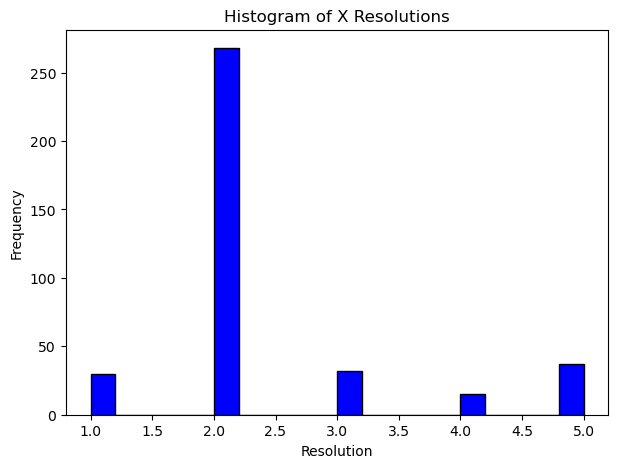

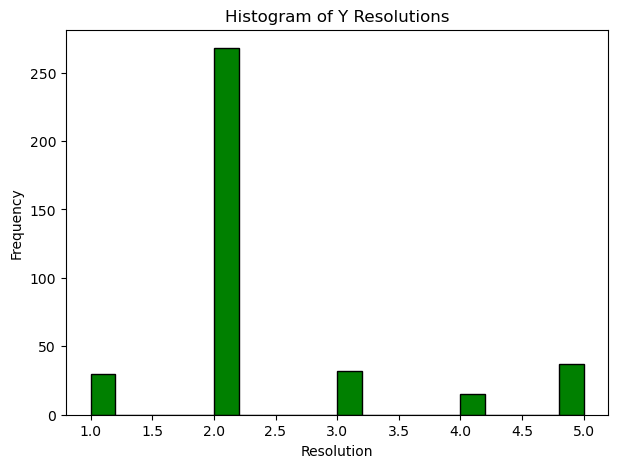

In [61]:
# Plot the histogram of X resolutions
plot_resolution_histogram(metadata, 'x')

# Plot the histogram of Y resolutions
plot_resolution_histogram(metadata, 'y')

In [62]:
# List the models with resolutions that are not exactly 2 meters for either axis
models_with_nonstandard_resolutions = list_models_with_nonstandard_resolution(metadata)
print("Models with resolution not exactly 2 meters:", models_with_nonstandard_resolutions)

Models with resolution not exactly 2 meters: ['00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00116', '00117', '00118', '00119', '00120', '00121', '00122', '00123', '00124', '00125', '00126', '00127', '00128', '00129', '00130', '00131', '00132', '00133', '00134', '00135', '00136', '00137', '00138', '00139', '00140', '00141', '00142', '00143', '00144', '00145', '00146', '00147', '00156', '00157', '00158', '00186', '00187', '00189', '00190', '00209', '00215', '00216', '00217', '00218', '00219', '00222', '00241', '00244', '00245', '00247', '00248', '00251', '00254', '00256', '00272', '00273', '00274', '00275', '00276', '00277', '00278', '00279', '00282', '00283', '00284', '00285', '00286', '00287', '00292', '00301', '00302', '00303', '00304', '00306', '00307', '00308', '00309', '00310', '00311', '00312', '00313', '00314', '00394', '00395', '00396', '00397', '00398', '00399', 

In [63]:
len(models_with_nonstandard_resolutions)

114

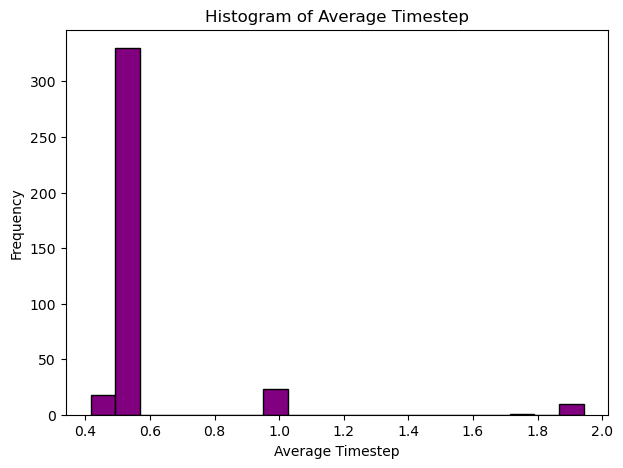

In [64]:
# Plot a histogram of average timestep
plot_average_timestep_histogram(metadata)

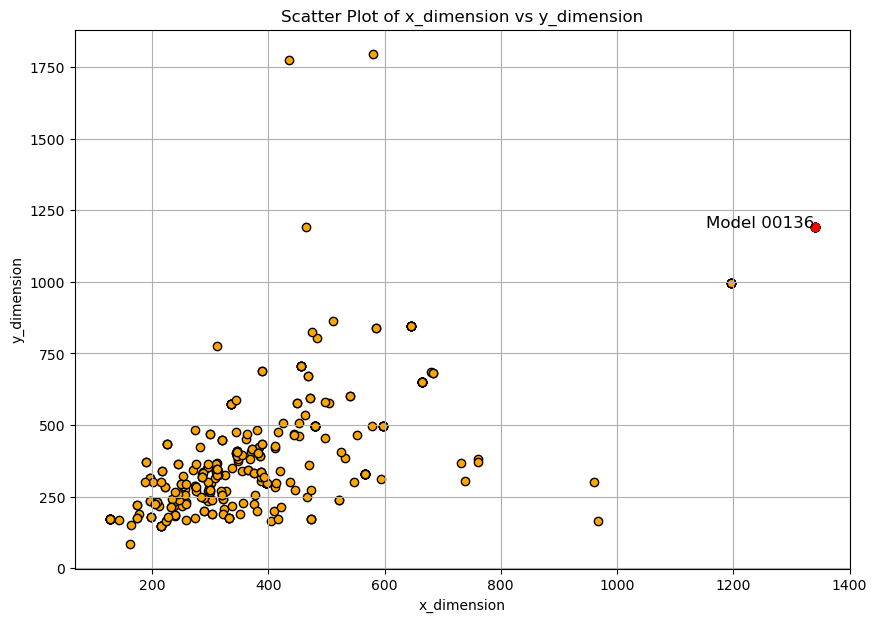

In [65]:
plot_dimensions_scatter(metadata)

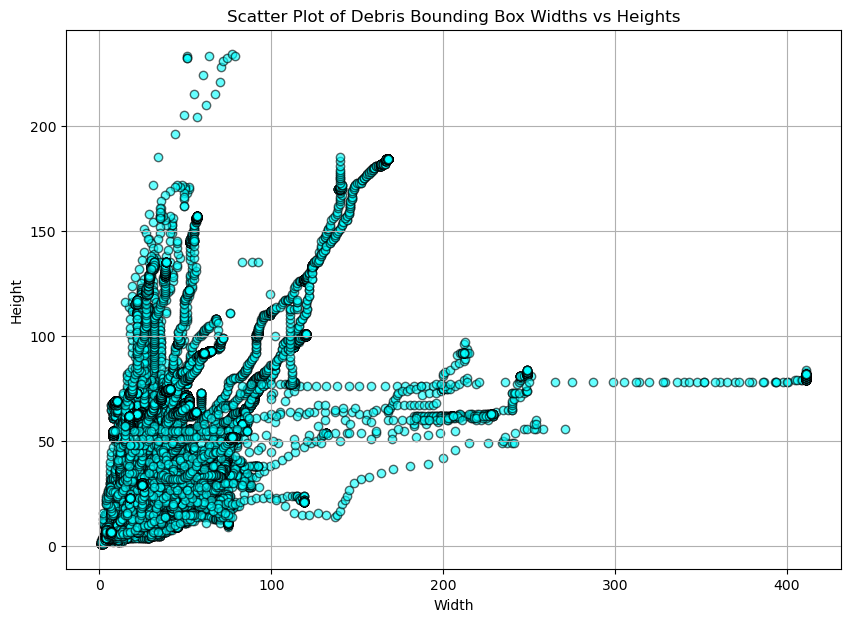

In [66]:
plot_debris_bounding_boxes(metadata)

In [67]:
diameter = 512
percentage = calculate_percentage_exceeding_diameter(metadata, diameter)
print(f"Percentage of bounding boxes exceeding {diameter}px: {percentage:.2f}%")

Percentage of bounding boxes exceeding 512px: 0.00%


In [68]:
diameter = 256
percentage = calculate_percentage_exceeding_diameter(metadata, diameter)
print(f"Percentage of bounding boxes exceeding {diameter}px: {percentage:.2f}%")

Percentage of bounding boxes exceeding 256px: 0.32%


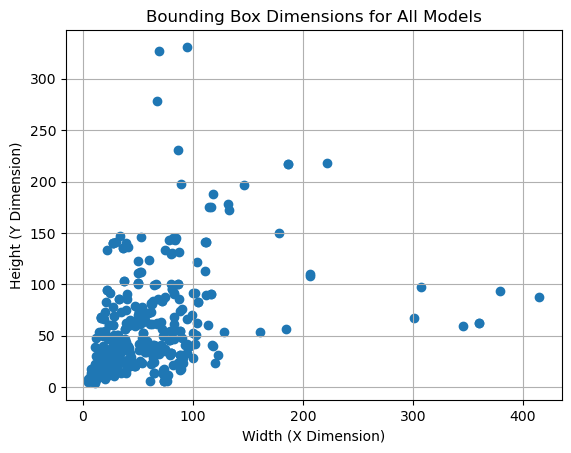

In [80]:
max_coverage_centers = plot_bounding_box_dimensions(metadata)